In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
!ls "/content/drive/My Drive/data_assign_2/hand_written_digits"  # List the contents of your dataset directory

0_digits  1_digits  2_digits


In [5]:
%cd /content/drive/MyDrive/data_assign_2/hand_written_digits

/content/drive/MyDrive/data_assign_2/hand_written_digits


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [7]:


# Define the path to your main dataset directory
data_dir = "/content/drive/My Drive/data_assign_2/hand_written_digits"

# Set parameters for data loading
batch_size = 32
img_height = 100
img_width = 100

# Load the training dataset
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # Specify the split ratio
    subset="training",     # Specify this is the training subset
    seed=123,              # Provide a seed for shuffling and transformations
    labels='inferred',     # Infer labels from the directory structure
    label_mode='int',  # Use 'categorical' for multi-class tasks, 'binary' for binary
    color_mode="grayscale",    # Specify the color mode as the images are in grayscale
    image_size=(img_height, img_width),  # Specify the target size of the images
    batch_size=batch_size
)

# Load the validation dataset
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,  # Specify the split ratio
    subset="validation",   # Specify this is the validation subset
    seed=123,              # Provide a seed for shuffling and transformations
    labels='inferred',     # Infer labels from the directory structure
    label_mode='int',  # Use 'categorical' for multi-class tasks, 'binary' for binary
    color_mode="grayscale",    # Specify the color mode as the images are in grayscale
    image_size=(img_height, img_width),  # Specify the target size of the images
    batch_size=batch_size
)

# Print out the class names (which are inferred from the directory structure)
print(train_ds.class_names)

# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 4658 files belonging to 3 classes.
Using 3727 files for training.
Found 4658 files belonging to 3 classes.
Using 931 files for validation.
['0_digits', '1_digits', '2_digits']


In [8]:
# Calculate the total size of the training dataset
train_size = tf.data.experimental.cardinality(train_ds).numpy()
print(f'Total number of batches in the training set: {train_size}')
print(f'Total number of images in the training set: {train_size * batch_size}')

# Calculate the total size of the validation dataset
val_size = tf.data.experimental.cardinality(val_ds).numpy()
print(f'Total number of batches in the validation set: {val_size}')
print(f'Total number of images in the validation set: {val_size * batch_size}')


Total number of batches in the training set: 117
Total number of images in the training set: 3744
Total number of batches in the validation set: 30
Total number of images in the validation set: 960


In [9]:
# Inspect one batch of the train dataset
for images, labels in train_ds.take(1):
    print("Train Dataset:")
    print(f"Images shape: {images.shape}")
    print(f"Images dtype: {images.dtype}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels dtype: {labels.dtype}")

# Inspect one batch of the validation dataset
for images, labels in val_ds.take(1):
    print("\nValidation Dataset:")
    print(f"Images shape: {images.shape}")
    print(f"Images dtype: {images.dtype}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels dtype: {labels.dtype}")


Train Dataset:
Images shape: (32, 100, 100, 1)
Images dtype: <dtype: 'float32'>
Labels shape: (32,)
Labels dtype: <dtype: 'int32'>

Validation Dataset:
Images shape: (32, 100, 100, 1)
Images dtype: <dtype: 'float32'>
Labels shape: (32,)
Labels dtype: <dtype: 'int32'>


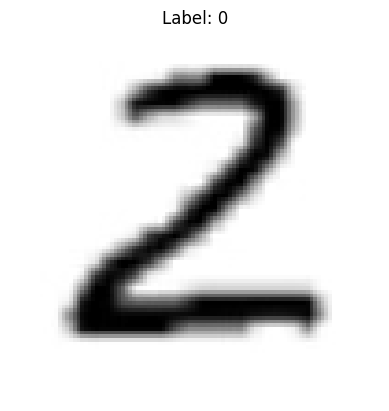

In [10]:
import matplotlib.pyplot as plt

# Take one batch from the training dataset
for images, labels in train_ds.take(1):
    # Extract the first image and label from the batch
    first_image = images[0].numpy().astype('uint8')
    first_label = labels[0].numpy()

    # Show the image
    plt.imshow(first_image[:, :, 0], cmap='gray')  # Display in grayscale
    plt.title(f'Label: {np.argmax(first_label)}')  # The label is one-hot encoded, so use argmax to get the label
    plt.axis('off')  # Turn off axis labels for clarity
    plt.show()
    break  # Only need the first batch, so break the loop


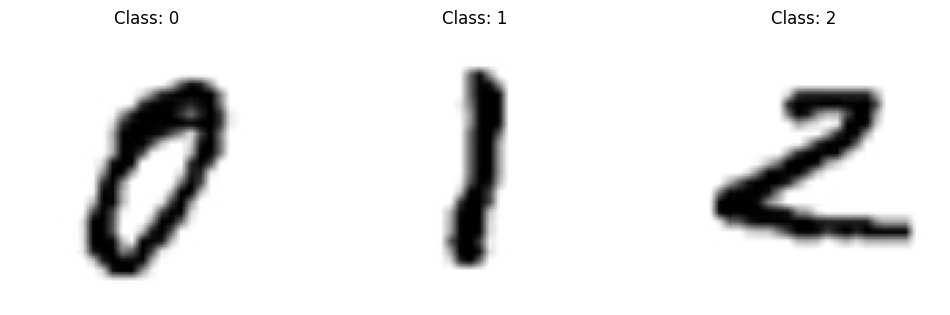

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare a dictionary to hold an example image for each class
example_images = {}

# Iterate over batches from the training dataset
for images, labels in train_ds:
    # The labels are already class indices when label_mode='int'
    class_indices = labels.numpy()

    # Loop through each image and its label in the current batch
    for img, class_idx in zip(images, class_indices):
        # If we don't already have an example for this class, add the image to the dictionary
        if class_idx not in example_images:
            example_images[class_idx] = img.numpy().astype('uint8')

        # If we have collected one example for each class, stop the search
        if len(example_images) == 3:  # Assuming there are 3 classes: 0, 1, 2
            break

    # Break the outer loop if we've found all examples
    if len(example_images) == 3:
        break

# Now, plot the example images
plt.figure(figsize=(12, 4))
for class_idx, img in example_images.items():
    plt.subplot(1, 3, class_idx+1)
    plt.imshow(img[:, :, 0], cmap='gray')  # Display in grayscale
    plt.title(f'Class: {class_idx}')
    plt.axis('off')
plt.show()


In [12]:
data_augmentation = Sequential([
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  # Add more augmentation options as needed but avoid flips that might misrepresent digits
])


In [13]:
# define the model

In [14]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    # Data augmentation layer
    data_augmentation,

    # 1st Convolutional Layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # 2nd Convolutional Layer
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Flattening followed by Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 classes
])


In [15]:
# complie the model

In [16]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [17]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [18]:
# train the model

In [19]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # You can increase this number based on your requirement
)


Epoch 1/10
117/117 [==============================] - 114s 954ms/step - loss: 0.4307 - accuracy: 0.9364 - val_loss: 2.8992 - val_accuracy: 0.8056
Epoch 2/10
117/117 [==============================] - 64s 549ms/step - loss: 0.1341 - accuracy: 0.9689 - val_loss: 16.4074 - val_accuracy: 0.4962
Epoch 3/10
117/117 [==============================] - 63s 535ms/step - loss: 0.1360 - accuracy: 0.9718 - val_loss: 2.1431 - val_accuracy: 0.7959
Epoch 4/10
117/117 [==============================] - 61s 518ms/step - loss: 0.1083 - accuracy: 0.9737 - val_loss: 30.2297 - val_accuracy: 0.6412
Epoch 5/10
117/117 [==============================] - 58s 495ms/step - loss: 0.1084 - accuracy: 0.9775 - val_loss: 17.3311 - val_accuracy: 0.5607
Epoch 6/10
117/117 [==============================] - 63s 538ms/step - loss: 0.0959 - accuracy: 0.9777 - val_loss: 0.0351 - val_accuracy: 0.9903
Epoch 7/10
117/117 [==============================] - 60s 509ms/step - loss: 0.0817 - accuracy: 0.9809 - val_loss: 0.1797 - va

In [20]:
# evalute the model

In [21]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_ds)

# Print the results
print(f'Validation accuracy: {val_accuracy*100:.2f}%')


30/30 [==============================] - 3s 87ms/step - loss: 162.0267 - accuracy: 0.3620
Validation accuracy: 36.20%


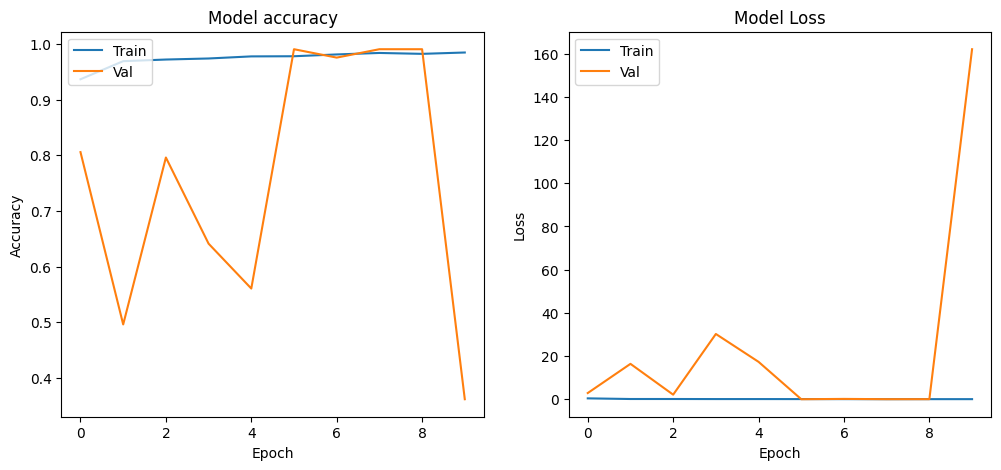

In [22]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
